In [1]:
import graphviz
import spacy

nlp = spacy.load('en') 

In [2]:
test_sent = nlp("""It is also recognised that the body of the receptacle can be configured to include only one resilient arm that is biased with respect to the wall of the body, thus facilitating the retention of the stylus between the one arm and the wall (and/or other rigid secondary structures of the body).""")

Direction in the graph is set by the parent>child relationship in the dependency parse. Nodes are the word tokens. I need to recursively navigate the dependency tree adding nodes and their relationships.

In [12]:
def build_graph(node):
    """ Print the subtree of a node."""
    # Add node to graph
    node_name = "{0}_{1}_{2}_{3}".format(node.text, node.pos_, node.dep_, node.i)
    dot.node(node_name)
    if node.children: # This will always be true as node.children is a generator
        for child in node.children:
            child_name = build_graph(child)
            dot.edge(node_name, child_name)
    return node_name

In [13]:
dot = graphviz.Digraph(comment='Dependency Tree')

In [15]:
root = list(test_sent.sents)[0].root
build_graph(root)

'recognised_VERB_ROOT_3'

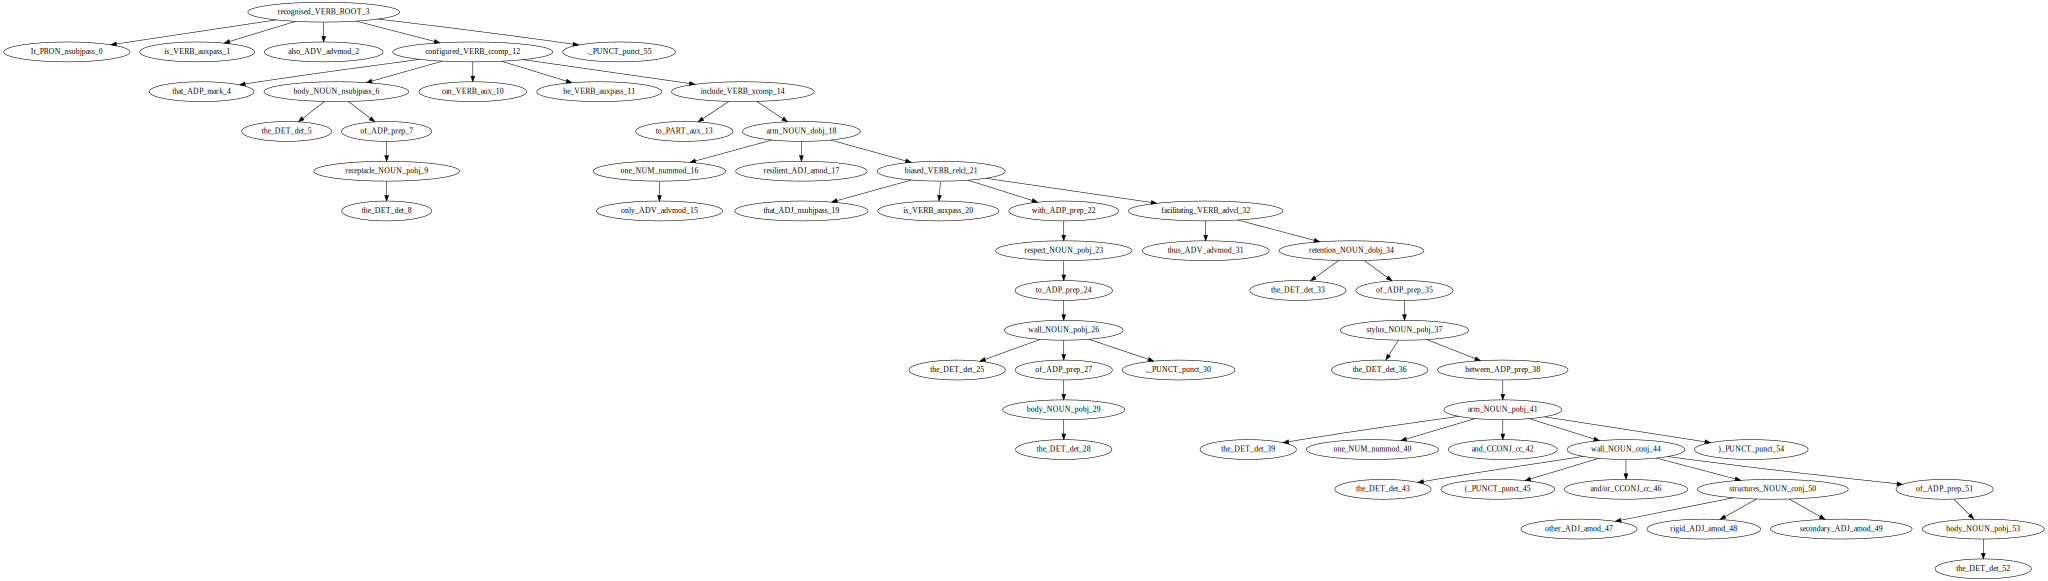

In [18]:
dot

In [19]:
dot.format = 'png'
dot.render()

'Digraph.gv.png'

Cool!

This helps a lot. We need to filter out nodes that have no children. The nodes that have children we can substitute in the graph and then handle the node + children separately.  

So we need to extract the subgraphs. Test is if child has children replace child with placeholder and add child structure to separate list.   

Process by layer at a time. Can we filter by size of subtree (e.g. in terms of number of nodes)? What we really want are the main subtrees not the puny little DET from NOUN subtrees.  

It's to do with numbers of children of subtrees

In [21]:
print(dot.source)

// Dependency Tree
digraph {
	recognised_VERB_ROOT_3
	It_PRON_nsubjpass_0
	recognised_VERB_ROOT_3 -> It_PRON_nsubjpass_0
	is_VERB_auxpass_1
	recognised_VERB_ROOT_3 -> is_VERB_auxpass_1
	also_ADV_advmod_2
	recognised_VERB_ROOT_3 -> also_ADV_advmod_2
	configured_VERB_ccomp_12
	that_ADP_mark_4
	configured_VERB_ccomp_12 -> that_ADP_mark_4
	body_NOUN_nsubjpass_6
	the_DET_det_5
	body_NOUN_nsubjpass_6 -> the_DET_det_5
	of_ADP_prep_7
	receptacle_NOUN_pobj_9
	the_DET_det_8
	receptacle_NOUN_pobj_9 -> the_DET_det_8
	of_ADP_prep_7 -> receptacle_NOUN_pobj_9
	body_NOUN_nsubjpass_6 -> of_ADP_prep_7
	configured_VERB_ccomp_12 -> body_NOUN_nsubjpass_6
	can_VERB_aux_10
	configured_VERB_ccomp_12 -> can_VERB_aux_10
	be_VERB_auxpass_11
	configured_VERB_ccomp_12 -> be_VERB_auxpass_11
	include_VERB_xcomp_14
	to_PART_aux_13
	include_VERB_xcomp_14 -> to_PART_aux_13
	arm_NOUN_dobj_18
	one_NUM_nummod_16
	only_ADV_advmod_15
	one_NUM_nummod_16 -> only_ADV_advmod_15
	arm_NOUN_dobj_18 -> one_NUM_nummod_16
	resilient_

In [27]:
subtrees = list()
parse_list = list()

def split_sentence(node):
    if node.children:
        layer_below = list()
        for child in node.lefts:
            if list(child.children):
                # Replace with token
                subtrees.append(child)
                layer_below.append(len(subtrees))
                # Split Sentence on token
                split_sentence(child)
            else:
                # Add to list of tokens we can print
                layer_below.append(child)
                
        layer_below.append(node)
        
        for child in node.rights:
            if list(child.children):
                # Replace with token
                subtrees.append(child)
                layer_below.append(len(subtrees))
                # Split Sentence on token
                split_sentence(child)
            else:
                # Add to list of tokens we can print
                layer_below.append(child)
    
    parse_list.append(layer_below)

In [28]:
split_sentence(root)

In [29]:
subtrees

[configured,
 body,
 of,
 receptacle,
 include,
 arm,
 one,
 biased,
 with,
 respect,
 to,
 wall,
 of,
 body,
 facilitating,
 retention,
 of,
 stylus,
 between,
 arm,
 wall,
 structures,
 of,
 body]

In [30]:
parse_list

[[the, receptacle],
 [of, 4],
 [the, body, 3],
 [only, one],
 [the, body],
 [of, 14],
 [the, wall, 13, ,],
 [to, 12],
 [respect, 11],
 [with, 10],
 [other, rigid, secondary, structures],
 [the, body],
 [of, 24],
 [the, wall, (, and/or, 22, 23],
 [the, one, arm, and, 21, )],
 [between, 20],
 [the, stylus, 19],
 [of, 18],
 [the, retention, 17],
 [thus, facilitating, 16],
 [that, is, biased, 9, 15],
 [7, resilient, arm, 8],
 [to, include, 6],
 [that, 2, can, be, configured, 5],
 [It, is, also, recognised, 1, .]]